# <span style="color:#0b486b">  FIT5215: Deep Learning (2023)</span>
***
*CE/Lecturer:* Dr **Trung Le** | trunglm@monash.edu <br/>
*Head Tutor:* Mr **Tuan Nguyen** | tuan.nguyen@monash.edu <br/>
<br/>
Department of Data Science and AI, Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
Surname: **Mishra**  <br/>
Firstname: **Siddharth**    <br/>
Student ID: **32304692**    <br/>
Email: **smis0018@student.monash.edu**    <br/>
Your tutorial time: **Thursday 1 to 3**    <br/>
***

## <span style="color:#0b486b">Assignment 02: Neural Embedding and Sequence Modelling</span>
### Due: <span style="color:red">11:59pm 22 October 2023</span>  (Sunday)

#### <span style="color:red">Important note:</span> This is an **individual** assignment. It contributes **20%** to you final mark. Read the assignment instruction carefully.

## <span style="color:#0b486b">Instructions</span>

This notebook has been prepared for your to complete Assignment 2. The theme of this assignment is about practical machine learning knowledge and skills in deep neural networks, word embedding and text analytics. Some sections have been partially completed to help you get
started. **The total marks for this notebook is 100**.

* Before you start, read the entire notebook carefully once to understand what you need to do. <br><br>
* For each cell marked with **#YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL**, there will be places where you **must** supply your own codes when instructed. <br>

This assignment contains **four** parts:

* Part 1: Questions on downloading and preprocessing data **[5 points]**
* Part 2: Questions on using Word2Vect to transform texts to vectors **[20 points]**
* Part 3: Coding assessment on BERT and CLIP for a feature extraction **[15 points]**
* Part 4: Coding assessment on RNNs for sequence modeling and neural embedding **[60 points]**


**Hint**: This assignment was essentially designed based on the lectures and tutorials sessions covered from Weeks 6 to 10. You are strongly recommended to go through these contents thoroughly which might help you to complete this assignment.

## <span style="color:#0b486b">What to submit</span>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <span style="color:red; font-weight:bold">single zip file, named xxx_assignment02_solution.zip</span> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**.

***For example, if your student ID is <span style="color:red; font-weight:bold">12356</span>, then gather all of your assignment solution to folder, create a zip file named <span style="color:red; font-weight:bold">123456_assignment02_solution.zip</span> and submit this file.***

Within this zip folder, you **must** submit the following files:
1.	**Assignment02_solution.ipynb**:  this is your Python notebook solution source file.
1.	**Assignment02_output.html**: this is the output of your Python notebook solution *exported* in html format.
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [1]:
import os

In [2]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

## <span style="color:#0b486b">Part 1: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 5 points]<span></div>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("drive/MyDrive/Colab Notebooks")

The dataset we use for this assignment is a question classification dataset for which the train set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR),
- entity (ENTY),
- description (DESC),
- human (HUM),
- location (LOC) and
- numeric (NUM).


Preprocessing data is an inital and important step in any machine learning or deep learning projects. The following *DataManager* class helps you to download data and preprocess data for the later questions of this assignment.

In [5]:
import os
import zipfile
import collections
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

class DataManager:
    def __init__(self, verbose=True, maxlen= 50, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = maxlen
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)

    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose= True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))

    def read_data(self, dir_name, file_names):
        self.str_questions= list(); self.str_labels= list()
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str= row.split(":")
                    label, question= row_str[0], row_str[1]
                    question= question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len= len(self.str_questions[-1])

        # turns labels into numbers
        le= preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes= le.classes_
        self.num_classes= len(self.str_classes)
        if self.verbose:
            print("\nSample questions... \n")
            print(self.str_questions[0:5])
            print("Labels {}\n\n".format(self.str_classes))

    def manipulate_data(self):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(self.str_questions)
        self.numeral_data = tokenizer.texts_to_sequences(self.str_questions)
        self.numeral_data = tf.keras.preprocessing.sequence.pad_sequences(self.numeral_data, padding='post', truncating= 'post', maxlen= self.maxlen)
        self.word2idx = tokenizer.word_index
        self.word2idx = {k:v for k,v in self.word2idx.items()}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)

    def train_valid_split(self, train_ratio=0.9):
        idxs = np.random.permutation(np.arange(len(self.str_questions)))
        train_size = int(train_ratio*len(idxs)) +1
        self.train_str_questions, self.valid_str_questions = self.str_questions[0:train_size], self.str_questions[train_size:]
        self.train_numeral_data, self.valid_numeral_data = self.numeral_data[0:train_size], self.numeral_data[train_size:]
        self.train_numeral_labels, self.valid_numeral_labels = self.numeral_labels[0:train_size], self.numeral_labels[train_size:]
        self.tf_train_set = tf.data.Dataset.from_tensor_slices((self.train_numeral_data, self.train_numeral_labels))
        self.tf_valid_set = tf.data.Dataset.from_tensor_slices((self.valid_numeral_data, self.valid_numeral_labels))

In [6]:
print('Loading data...')
DataManager.maybe_download("Data", "train_1000.label", "http://cogcomp.org/Data/QA/QC/")
DataManager.maybe_download("Data", "TREC_10.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("Data/", ["train_1000.label", "TREC_10.label"])   # read data
# If you want to play around with a bigger dataset, you can try train_set.label

Loading data...
Downloaded successfully train_1000.label
Downloaded successfully TREC_10.label

Sample questions... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
Labels ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']




In [7]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

#### <span style="color:red">**Question 1.1**</span>
**What is the purpose of `self.train_str_questions` and `self.train_numeral_labels`? Write your code to print out the first five questions with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div>

#Your answer here




The attributes self.train_str_questions and self.train_numeral_labels store the training data's questions and labels, respectively.

self.train_str_questions: Stores the actual questions in string format.


self.train_numeral_labels: Stores the corresponding labels in numeral (encoded) format.

In [8]:
for question, label in zip(dm.train_str_questions[:5], dm.train_numeral_labels[:5]):
    print("Question:", question)
    print("Label (encoded):", label)
    print("Label (string):", dm.str_classes[label])
    print("------------------------")


Question: manner how did serfdom develop in and then leave russia ?
Label (encoded): 1
Label (string): DESC
------------------------
Question: cremat what films featured the character popeye doyle ?
Label (encoded): 2
Label (string): ENTY
------------------------
Question: manner how can i find a list of celebrities ' real names ?
Label (encoded): 1
Label (string): DESC
------------------------
Question: animal what fowl grabs the spotlight after the chinese year of the monkey ?
Label (encoded): 2
Label (string): ENTY
------------------------
Question: exp what is the full form of .com ?
Label (encoded): 0
Label (string): ABBR
------------------------


#### <span style="color:red">**Question 1.2**</span>
**What is the purpose of `self.train_numeral_data`? Write your code to print out the first five questions in the numeric format with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div>

#Your answer here




The attribute self.train_numeral_data stores the training data's questions in a numeric (or encoded) format. Specifically:

self.train_numeral_data: Contains the questions where each word in the question has been mapped to a unique integer (tokenized) based on its frequency or occurrence in the dataset. This numeric representation is useful for neural networks and other machine learning models, as they work with numeric data rather than raw text.

In [9]:
#Your code here
for question_numeric, label in zip(dm.train_numeral_data[:5], dm.train_numeral_labels[:5]):
    print("Question (numeric):", question_numeric)
    print("Label (encoded):", label)
    print("Label (string):", dm.str_classes[label])
    print("------------------------")



Question (numeric): [  35   11   18 1030 1031    5   25  561 1032  562    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Label (encoded): 1
Label (string): DESC
------------------------
Question (numeric): [  43    2  563 1033    1  164 1034 1035    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 

#### <span style="color:red">**Question 1.3**</span>
**What is the purpose of two dictionaries: `self.word2idx` and `self.idx2word`? Write your code to print out the first five key-value pairs of those dictionaries.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div>

#Your answer here





The purpose of the two dictionaries, self.word2idx and self.idx2word, is to create a mapping between words in the dataset and their respective unique integers:

self.word2idx: This dictionary maps words (strings) to their corresponding unique integers (tokens). It's used to convert a sentence from a string format to a numeric format where each word is represented by its corresponding unique integer.
self.idx2word: This dictionary is the reverse mapping of self.word2idx. It maps the unique integers (tokens) back to their corresponding words (strings). It's primarily used for converting predictions or any numeric representation of a sentence back to its string format.

In [10]:
# Printing for word2idx
print("word2idx:")
for idx, (word, value) in enumerate(dm.word2idx.items()):
    if idx >= 5:
        break
    print(word, ":", value)

print("------------------------")

# Printing for idx2word
print("idx2word:")
for idx, (token, word) in enumerate(dm.idx2word.items()):
    if idx >= 5:
        break
    print(token, ":", word)


word2idx:
the : 1
what : 2
is : 3
of : 4
in : 5
------------------------
idx2word:
1 : the
2 : what
3 : is
4 : of
5 : in


#### <span style="color:red">**Question 1.4**</span>
**What is the purpose of `self.tf_train_set`? Write your code to print out the first five items of `self.tf_train_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div>

The self.tf_train_set variable is a TensorFlow Dataset (tf.data.Dataset) representing the training data. The TensorFlow Dataset API provides a way to handle large amounts of data, stream it in efficient manners, and easily apply transformations. In this context, self.tf_train_set is created from the tokenized and padded training questions (self.train_numeral_data) and their corresponding labels (self.train_numeral_labels).

#Your answer here



In [11]:
#Your code here
counter = 0
for data, label in dm.tf_train_set:
    print("Data:", data.numpy())
    print("Label:", label.numpy())
    counter += 1
    if counter == 5:
        break


Data: [  35   11   18 1030 1031    5   25  561 1032  562    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Label: 1
Data: [  43    2  563 1033    1  164 1034 1035    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    

#### <span style="color:red">**Question 1.5**</span>
**What is the purpose of `self.tf_valid_set`? Write your code to print out the first five items of `self.tf_valid_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div>

#Your answer here



The self.tf_valid_set variable is another TensorFlow Dataset (tf.data.Dataset), but this one is intended to represent the validation data. While self.tf_train_set is used to train the model, self.tf_valid_set would be used to validate the model's performance on data it hasn't been trained on. Validating a model on unseen data helps in gauging its generalization capabilities and avoiding overfitting.

In [12]:
#Your code here
counter = 0
for data, label in dm.tf_valid_set:
    print("Data:", data.numpy())
    print("Label:", label.numpy())
    counter += 1
    if counter == 5:
        break


Data: [  23    2   23   13  243    3   53    1 3031   20    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Label: 4
Data: [   6   12   98    1 3032    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    

## <span style="color:#0b486b">Part 2: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 points]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a Support Vector Machine in sckit-learn.  

In [13]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

#### <span style="color:red">**Question 2.1**</span>
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [14]:
word2vect = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


#### <span style="color:red">**Question 2.2**</span>

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[3 points]</span></div>

In [15]:
def get_word_vector(word, model):
    try:
        vector = model[word]   # Get the vector for the given word from the model
    except: # word not in the vocabulary
        vector = np.zeros(100)  # Return a 100-dimensional zero vector
    return vector

#### <span style="color:red">**Question 2.3**</span>

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[L]\times v[L]$ where $L$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if `important_score=None` is set by default, your function should return the average of all representation vectors corresponding to set `important_score=[1,1,...,1]`.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [16]:
import numpy as np

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def get_word_vector(word, model):
    try:
        return model[word]
    except:
        return np.zeros(100)

def get_sentence_vector(sentence, important_score=None, model=None):
    # Tokenize the sentence into words
    words = sentence.split()

    # If no important_score provided, initialize it as an array of ones
    if important_score is None:
        important_score = [1] * len(words)

    # Ensure the length matches
    assert len(words) == len(important_score), "Mismatch between number of words and scores"

    # Compute the softmax over important scores to get weights
    important_weight = softmax(np.array(important_score))

    # Compute the weighted sum of word vectors
    sentence_vector = sum(get_word_vector(word, model) * weight for word, weight in zip(words, important_weight))

    return sentence_vector


#### <span style="color:red">**Question 2.4**</span>

**Write code to transform the training questions in *dm.train_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_train$ which is an numpy array of the feature vectors and $y\_train$ which is an array of numeric labels (*Hint: dm.train_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [17]:
print("Transform training set to feature vectors...")

# Create an importance score function that decays the score exponentially
def get_importance_scores(length, decay_rate=0.9):
    return [decay_rate ** i for i in range(length)]

# Transform each training question into its feature vector representation
X_train = np.array([get_sentence_vector(question, get_importance_scores(len(question.split())), word2vect) for question in dm.train_str_questions])

# Extract the training labels
y_train = np.array(dm.train_numeral_labels)

Transform training set to feature vectors...


#### <span style="color:red">**Question 2.5**</span>

**Write code to transform the training questions in *dm.valid_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_valid$ which is an numpy array of the feature vectors and $y\_valid$ which is an array of numeric labels (*Hint: dm.valid_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [18]:
print("Transform valid set to feature vectors...")

# Transform each validation question into its feature vector representation using the same importance scores
X_valid = np.array([get_sentence_vector(question, get_importance_scores(len(question.split())), word2vect) for question in dm.valid_str_questions])

# Extract the validation labels
y_valid = np.array(dm.valid_numeral_labels)

Transform valid set to feature vectors...


#### <span style="color:red">**Question 2.6**</span>

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in sckit-learn to scale both training and valid sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [19]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler only on the training data
scaler.fit(X_train)

# Transform both training and validation data using the fitted scaler
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)  # Note: we don't fit the scaler on validation data to prevent data leakage


#### <span style="color:red">**Question 2.7**</span>

**Declare a support vector machine (the class *SVC*  in sckit-learn) with RBF kernel, $C=1$, $gamma= 2^{-3}$ and fit on the training set.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [20]:
# Declare the SVM with the given parameters
svm = SVC(kernel='rbf', C=1, gamma=2**-3)

# Fit the SVM model on the training data
svm.fit(X_train, y_train)

SVC(C=1, gamma=0.125)

#### <span style="color:red">**Question 2.8**</span>

**Finally, we use the trained *svm* to evaluate on the valid set $X\_valid$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [21]:
# Use the trained SVM to predict labels for the validation set
y_valid_pred = svm.predict(X_valid)

# Calculate the accuracy by comparing the predicted labels to the true labels
acc = accuracy_score(y_valid, y_valid_pred)

print(acc)

0.9498327759197325


## <span style="color:#0b486b">Part 3: Sentence representation with BERT and CLIP </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 15 points]<span></div>

#### <span style="color:red">**Question 3.1**</span>
**Use a pretrained BERT model to extract feaure vectors for the training and valid sets. You should choose an appropriate pretrained BERT model that fits your computational resource.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [22]:
!pip install transformers tensorflow

import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.3 MB/s eta 0:00:00


In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [24]:
def extract_bert_features(sentences, tokenizer, model):
    encodings = tokenizer(sentences, return_tensors='tf', padding=True, truncation=True, max_length=512)
    outputs = model(encodings['input_ids'], attention_mask=encodings['attention_mask'])
    return tf.reduce_mean(outputs[0], axis=1).numpy()



X_train_bert = extract_bert_features(dm.train_str_questions, tokenizer, model)
X_valid_bert = extract_bert_features(dm.valid_str_questions, tokenizer, model)


#### <span style="color:red">**Question 3.2**</span>
**Conduct a feed-forward neural network to train on the training set of feature vectors extracted from BERT and then evaluate on the valid set.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the neural network architecture
model_nn = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_bert.shape[1],)),  # input shape should match the BERT embeddings dimension
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(set(dm.train_numeral_labels)), activation='softmax')  # number of classes
])

# Compile the model
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_nn.fit(X_train_bert, dm.train_numeral_labels, epochs=10, batch_size=32, validation_data=(X_valid_bert, dm.valid_numeral_labels))

# Evaluate on the validation set
loss, accuracy = model_nn.evaluate(X_valid_bert, dm.valid_numeral_labels)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


Epoch 1/10
38/38 [==============================] - 2s 17ms/step - loss: 1.0530 - accuracy: 0.6087 - val_loss: 0.3660 - val_accuracy: 0.8896
Epoch 2/10
38/38 [==============================] - 1s 14ms/step - loss: 0.3943 - accuracy: 0.8668 - val_loss: 0.2167 - val_accuracy: 0.9164
Epoch 3/10
38/38 [==============================] - 0s 13ms/step - loss: 0.1920 - accuracy: 0.9359 - val_loss: 0.1889 - val_accuracy: 0.9264
Epoch 4/10
38/38 [==============================] - 1s 13ms/step - loss: 0.1526 - accuracy: 0.9450 - val_loss: 0.0739 - val_accuracy: 0.9732
Epoch 5/10
38/38 [==============================] - 0s 13ms/step - loss: 0.1081 - accuracy: 0.9725 - val_loss: 0.0909 - val_accuracy: 0.9666
Epoch 6/10
38/38 [==============================] - 0s 12ms/step - loss: 0.0843 - accuracy: 0.9709 - val_loss: 0.1223 - val_accuracy: 0.9565
Epoch 7/10
38/38 [==============================] - 0s 11ms/step - loss: 0.0545 - accuracy: 0.9850 - val_loss: 0.1225 - val_accuracy: 0.9599
Epoch 8/10
38

#### <span style="color:red">**Question 3.3**</span>
**Use a pretrained CLIP model to extract feaure vectors for the training and valid sets. You should choose an appropriate pretrained CLIP model that fits your computational resource.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [26]:
from transformers import TFCLIPTextModel, CLIPTokenizer

model_name = "openai/clip-vit-base-patch16"
clip_model = TFCLIPTextModel.from_pretrained(model_name, from_pt=True)
clip_tokenizer = CLIPTokenizer.from_pretrained(model_name)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCLIPTextModel: ['vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.3.layer_norm1.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.weight', 'vision_model.encoder.layers.9.layer_norm2.bias', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.8.self_attn.k_proj.weight', 'vision_model.encoder.layers.5.self_attn.q_proj.bias', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.6.self_attn.out_proj.bias', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.9.self_attn.k_proj.weight', 'vision_model.encoder.layers.4.layer_norm2.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.mlp.fc2.bias', 'vision_model.encoder.layers.7.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.layer_nor

In [27]:
def extract_clip_features_tf(sentences, tokenizer, model):
    # Tokenize sentences and produce tensor outputs
    inputs = tokenizer(sentences, return_tensors="tf", padding=True, truncation=True, max_length=77)  # CLIP's max length is 77
    # Extract the embeddings
    outputs = model(inputs.input_ids, attention_mask=inputs.attention_mask).last_hidden_state
    # Get the mean of the token embeddings for a representation of the entire sentence
    sentence_embeddings = tf.reduce_mean(outputs, axis=1)
    return sentence_embeddings.numpy()

In [28]:
# For the training set
X_train_clip = extract_clip_features_tf(dm.train_str_questions, clip_tokenizer, clip_model)

# For the validation set
X_valid_clip = extract_clip_features_tf(dm.valid_str_questions, clip_tokenizer, clip_model)


#### <span style="color:red">**Question 3.4**</span>
**Conduct a feed-forward neural network to train on the training set of feature vectors extracted from CLIP and then evaluate on the valid set.**
<div style="text-align: right"><span style="color:red">[3 points]</span></div>

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming your label data is stored in `dm.train_numeral_labels` for training and `dm.valid_numeral_labels` for validation

# 1. Define the neural network architecture
model_clip_nn = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_clip.shape[1],)),  # input shape should match the CLIP embeddings dimension
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(set(dm.train_numeral_labels)), activation='softmax')  # number of classes
])

# 2. Compile the model
model_clip_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3. Train the model
model_clip_nn.fit(X_train_clip, dm.train_numeral_labels, epochs=10, batch_size=32, validation_data=(X_valid_clip, dm.valid_numeral_labels))

# 4. Evaluate on the validation set
loss, accuracy = model_clip_nn.evaluate(X_valid_clip, dm.valid_numeral_labels)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


Epoch 1/10
38/38 [==============================] - 1s 15ms/step - loss: 1.3226 - accuracy: 0.4954 - val_loss: 0.5496 - val_accuracy: 0.8361
Epoch 2/10
38/38 [==============================] - 1s 15ms/step - loss: 0.5502 - accuracy: 0.8093 - val_loss: 0.3451 - val_accuracy: 0.8763
Epoch 3/10
38/38 [==============================] - 1s 16ms/step - loss: 0.3234 - accuracy: 0.8876 - val_loss: 0.1915 - val_accuracy: 0.9264
Epoch 4/10
38/38 [==============================] - 1s 17ms/step - loss: 0.2205 - accuracy: 0.9201 - val_loss: 0.1748 - val_accuracy: 0.9331
Epoch 5/10
38/38 [==============================] - 1s 14ms/step - loss: 0.1578 - accuracy: 0.9492 - val_loss: 0.1669 - val_accuracy: 0.9465
Epoch 6/10
38/38 [==============================] - 1s 14ms/step - loss: 0.1072 - accuracy: 0.9650 - val_loss: 0.2097 - val_accuracy: 0.9264
Epoch 7/10
38/38 [==============================] - 1s 14ms/step - loss: 0.0905 - accuracy: 0.9709 - val_loss: 0.1910 - val_accuracy: 0.9264
Epoch 8/10
38

## <span style="color:#0b486b">Part 4: RNNs for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 60 points]<span></div>

### <span style="color:#0b486b">4.1. One-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.1.1**</span>
**In this part, you need to construct an RNN to learn from the dataset of interest. Basically, you are required first to construct the class UniRNN (Uni-directional RNN) with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can receive three values including `basic_rnn`, `gru`, and `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [30]:
import tensorflow as tf

class UniRNN:
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 64], data_manager=None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size + 1

    @staticmethod
    def get_layer(cell_type='gru', state_size=128, return_sequences=False, activation='tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.GRU(state_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            return tf.keras.layers.LSTM(state_size, return_sequences=return_sequences, activation=activation)
        else:
            return tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences, activation=activation)

    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size, mask_zero=True)(x)

        num_layers = len(self.state_sizes)
        for i, state_size in enumerate(self.state_sizes):
            return_seq = True if i < num_layers - 1 else False
            h = self.get_layer(self.cell_type, state_size, return_sequences=return_seq)(h)

        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 4.1.2**</span>
**Run with basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [31]:
uni_rnn = UniRNN(cell_type='basic_rnn', embed_size=128, state_sizes=[64, 128], data_manager=dm)
uni_rnn.build()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))


Epoch 1/20
19/19 [==============================] - 5s 148ms/step - loss: 0.9634 - accuracy: 0.6619 - val_loss: 0.4328 - val_accuracy: 0.8629
Epoch 2/20
19/19 [==============================] - 4s 212ms/step - loss: 0.2146 - accuracy: 0.9317 - val_loss: 0.2125 - val_accuracy: 0.9398
Epoch 3/20
19/19 [==============================] - 2s 121ms/step - loss: 0.1314 - accuracy: 0.9625 - val_loss: 0.1767 - val_accuracy: 0.9465
Epoch 4/20
19/19 [==============================] - 2s 128ms/step - loss: 0.0503 - accuracy: 0.9858 - val_loss: 0.1508 - val_accuracy: 0.9498
Epoch 5/20
19/19 [==============================] - 2s 132ms/step - loss: 0.0270 - accuracy: 0.9950 - val_loss: 0.1756 - val_accuracy: 0.9532
Epoch 6/20
19/19 [==============================] - 3s 145ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.1190 - val_accuracy: 0.9666
Epoch 7/20
19/19 [==============================] - 4s 212ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.1451 - val_accuracy: 0.9666
Epoch 

#### <span style="color:red">**Question 4.1.3**</span>
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [32]:

uni_rnn = UniRNN(cell_type='gru', embed_size=128, state_sizes=[64, 128], data_manager=dm)
uni_rnn.build()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))


Epoch 1/20
19/19 [==============================] - 21s 668ms/step - loss: 1.6951 - accuracy: 0.2673 - val_loss: 1.5790 - val_accuracy: 0.4749
Epoch 2/20
19/19 [==============================] - 9s 500ms/step - loss: 1.4442 - accuracy: 0.3730 - val_loss: 1.0332 - val_accuracy: 0.5351
Epoch 3/20
19/19 [==============================] - 7s 364ms/step - loss: 0.8858 - accuracy: 0.6211 - val_loss: 0.6731 - val_accuracy: 0.7826
Epoch 4/20
19/19 [==============================] - 10s 541ms/step - loss: 0.5085 - accuracy: 0.8376 - val_loss: 0.4105 - val_accuracy: 0.8930
Epoch 5/20
19/19 [==============================] - 6s 334ms/step - loss: 0.2479 - accuracy: 0.9292 - val_loss: 0.2529 - val_accuracy: 0.9164
Epoch 6/20
19/19 [==============================] - 10s 539ms/step - loss: 0.0938 - accuracy: 0.9784 - val_loss: 0.3521 - val_accuracy: 0.9264
Epoch 7/20
19/19 [==============================] - 7s 348ms/step - loss: 0.0485 - accuracy: 0.9908 - val_loss: 0.1171 - val_accuracy: 0.9532
Epo

#### <span style="color:red">**Question 4.1.4**</span>
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [33]:

uni_rnn = UniRNN(cell_type='lstm', embed_size=128, state_sizes=[64, 128], data_manager=dm)
uni_rnn.build()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))


Epoch 1/20
19/19 [==============================] - 23s 733ms/step - loss: 1.7072 - accuracy: 0.2864 - val_loss: 1.5679 - val_accuracy: 0.5351
Epoch 2/20
19/19 [==============================] - 9s 495ms/step - loss: 1.1998 - accuracy: 0.5412 - val_loss: 0.9976 - val_accuracy: 0.7425
Epoch 3/20
19/19 [==============================] - 9s 463ms/step - loss: 0.6839 - accuracy: 0.7893 - val_loss: 0.6812 - val_accuracy: 0.8562
Epoch 4/20
19/19 [==============================] - 11s 605ms/step - loss: 0.3974 - accuracy: 0.8976 - val_loss: 0.4022 - val_accuracy: 0.9030
Epoch 5/20
19/19 [==============================] - 17s 917ms/step - loss: 0.2226 - accuracy: 0.9450 - val_loss: 0.3315 - val_accuracy: 0.9030
Epoch 6/20
19/19 [==============================] - 16s 806ms/step - loss: 0.1476 - accuracy: 0.9667 - val_loss: 0.3169 - val_accuracy: 0.8930
Epoch 7/20
19/19 [==============================] - 20s 1s/step - loss: 0.1391 - accuracy: 0.9709 - val_loss: 0.3687 - val_accuracy: 0.9197
Epoc

### <span style="color:#0b486b">4.2. Bi-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.2.1**</span>
**In what follow, you will investigate BiRNN. The task is similar to Part 5.1 but you need to write the code for an BiRNN. Note that the function *get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh')* has to return the hidden layer with bidirectional memory cells (e.g., Basic RNN, GRU, and LSTM cells).**

**Complete the code of the class *BiRNN*. Note that for the embedding layer you need to set *mask_zero=True*.**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [34]:
class BiRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1

    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size, return_sequences=return_sequences, activation=activation))
        elif cell_type == 'lstm':
            return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, return_sequences=return_sequences, activation=activation))
        else:  # basic rnn
            return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences, activation=activation))

    def build(self):
        x = tf.keras.layers.Input(shape=[None])

        # Embedding layer with mask_zero=True
        h = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size, mask_zero=True)(x)

        num_layers = len(self.state_sizes)
        for state_size in self.state_sizes:
            h = BiRNN.get_layer(self.cell_type, state_size, return_sequences=(num_layers > 1), activation='tanh')(h)
            num_layers -= 1  # decrease the count

        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)

#### <span style="color:red">**Question 4.2.2**</span>
**Run BiRNN for basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [35]:
# Instantiate BiRNN with basic RNN cell and given parameters
bi_rnn = BiRNN(cell_type='basic_rnn', embed_size=128, state_sizes=[64, 128], data_manager=dm)

# Build the model
bi_rnn.build()

# Set the optimizer and compile the model
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))


Epoch 1/20
19/19 [==============================] - 20s 608ms/step - loss: 0.6936 - accuracy: 0.7685 - val_loss: 0.2581 - val_accuracy: 0.9331
Epoch 2/20
19/19 [==============================] - 8s 417ms/step - loss: 0.1000 - accuracy: 0.9684 - val_loss: 0.1389 - val_accuracy: 0.9465
Epoch 3/20
19/19 [==============================] - 5s 246ms/step - loss: 0.0198 - accuracy: 0.9983 - val_loss: 0.1113 - val_accuracy: 0.9666
Epoch 4/20
19/19 [==============================] - 7s 359ms/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.1253 - val_accuracy: 0.9666
Epoch 5/20
19/19 [==============================] - 5s 281ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1190 - val_accuracy: 0.9632
Epoch 6/20
19/19 [==============================] - 5s 251ms/step - loss: 6.3919e-04 - accuracy: 1.0000 - val_loss: 0.1212 - val_accuracy: 0.9632
Epoch 7/20
19/19 [==============================] - 7s 403ms/step - loss: 3.6813e-04 - accuracy: 1.0000 - val_loss: 0.1232 - val_accuracy: 0.96

#### <span style="color:red">**Question 4.2.3**</span>
**Run BiRNN for GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [36]:
# Instantiate BiRNN with GRU cell and given parameters
bi_rnn = BiRNN(cell_type='gru', embed_size=128, state_sizes=[64, 128], data_manager=dm)

# Build the model
bi_rnn.build()

# Set the optimizer and compile the model
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 40s 1s/step - loss: 1.6020 - accuracy: 0.3480 - val_loss: 1.2945 - val_accuracy: 0.8562
Epoch 2/20
19/19 [==============================] - 17s 887ms/step - loss: 0.7984 - accuracy: 0.8243 - val_loss: 0.5833 - val_accuracy: 0.7926
Epoch 3/20
19/19 [==============================] - 17s 881ms/step - loss: 0.2701 - accuracy: 0.9226 - val_loss: 0.3501 - val_accuracy: 0.8930
Epoch 4/20
19/19 [==============================] - 17s 890ms/step - loss: 0.1102 - accuracy: 0.9659 - val_loss: 0.3301 - val_accuracy: 0.8863
Epoch 5/20
19/19 [==============================] - 17s 890ms/step - loss: 0.0576 - accuracy: 0.9792 - val_loss: 0.1900 - val_accuracy: 0.9298
Epoch 6/20
19/19 [==============================] - 16s 862ms/step - loss: 0.0247 - accuracy: 0.9908 - val_loss: 0.1804 - val_accuracy: 0.9431
Epoch 7/20
19/19 [==============================] - 16s 812ms/step - loss: 0.0133 - accuracy: 0.9975 - val_loss: 0.1941 - val_accuracy: 0.9565
Ep

#### <span style="color:red">**Question 4.2.4**</span>
**Run BiRNN for LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [37]:
# Instantiate BiRNN with LSTM cell and the provided parameters
bi_rnn = BiRNN(cell_type='lstm', embed_size=128, state_sizes=[64, 128], data_manager=dm)

# Build the model
bi_rnn.build()

# Define the optimizer and compile the model
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))


Epoch 1/20
19/19 [==============================] - 48s 2s/step - loss: 1.7007 - accuracy: 0.2939 - val_loss: 1.5999 - val_accuracy: 0.4816
Epoch 2/20
19/19 [==============================] - 22s 1s/step - loss: 1.2050 - accuracy: 0.5903 - val_loss: 0.8865 - val_accuracy: 0.8094
Epoch 3/20
19/19 [==============================] - 20s 1s/step - loss: 0.6128 - accuracy: 0.8210 - val_loss: 0.5444 - val_accuracy: 0.8729
Epoch 4/20
19/19 [==============================] - 18s 982ms/step - loss: 0.3569 - accuracy: 0.9017 - val_loss: 0.3729 - val_accuracy: 0.9097
Epoch 5/20
19/19 [==============================] - 19s 999ms/step - loss: 0.1506 - accuracy: 0.9642 - val_loss: 0.2355 - val_accuracy: 0.9197
Epoch 6/20
19/19 [==============================] - 19s 1s/step - loss: 0.0768 - accuracy: 0.9792 - val_loss: 0.1837 - val_accuracy: 0.9565
Epoch 7/20
19/19 [==============================] - 20s 1s/step - loss: 0.0283 - accuracy: 0.9958 - val_loss: 0.1620 - val_accuracy: 0.9565
Epoch 8/20
19/

### <span style="color:#0b486b">4.3. RNNs with various types, cells, and fine-tuning embedding matrix for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.3.1**</span>

**In what follows, you are required to combine the code in Part 1 and Part 2 to gain a general RNN which can be either Uni-directional RNN or Bi-directional RNN and the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `network_type (self.network_type)` has two values (uni-directional and bi-directional) which correspond to either Uni-directional RNN or Bi-directional RNN.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[6 points]</span></div>

In [38]:
import gensim.downloader as api
import numpy as np
import tensorflow as tf

class RNN:
    def __init__(self, run_mode='scratch', cell_type='gru', network_type='uni-directional',
                 embed_model='glove-wiki-gigaword-100', embed_size=128, state_sizes=[64, 64],
                 data_manager=None, word2vect=None):
        self.run_mode = run_mode
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = data_manager.vocab_size + 1
        self.word2idx = data_manager.word2idx
        self.word2vect = word2vect
        self.embed_matrix = np.zeros((self.vocab_size, self.embed_size))

    def build_embedding_matrix(self):
        for word, i in self.word2idx.items():
            try:
                self.embed_matrix[i] = self.word2vect[word]
            except KeyError:
                pass  # word not in pretrained model, so it remains zero

    @staticmethod
    def get_layer(cell_type='gru', network_type='uni-directional', hidden_size=128,
                  return_sequences=False, activation='tanh'):
        if cell_type == 'simple-rnn':
            cell = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'gru':
            cell = tf.keras.layers.GRU(hidden_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            cell = tf.keras.layers.LSTM(hidden_size, return_sequences=return_sequences, activation=activation)

        if network_type == 'bi-directional':
            return tf.keras.layers.Bidirectional(cell)
        else:
            return cell

    def build(self):
        x = tf.keras.layers.Input(shape=[None])

        if self.run_mode == 'scratch':
            h = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size, mask_zero=True)(x)
        else:
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size,
                                          weights=[self.embed_matrix], trainable=(self.run_mode == 'init-fine-tune'),
                                          mask_zero=True)(x)

        num_layers = len(self.state_sizes)
        for hidden_size in self.state_sizes:
            h = self.get_layer(self.cell_type, self.network_type, hidden_size,
                               return_sequences=(num_layers > 1))(h)
            num_layers -= 1

        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        return self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 4.3.2**</span>

**Design the experiment to compare three running modes. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments for the results.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [39]:
run_modes = ['scratch', 'init-only', 'init-fine-tune']
results = {}

for mode in run_modes:
    print(f"Training model in {mode} mode...")
    rnn = RNN(run_mode=mode, cell_type='gru', network_type='uni-directional',
              embed_model='glove-wiki-gigaword-100', state_sizes=[64, 64], data_manager=dm, word2vect=word2vect)
    rnn.build()

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

    val_metrics = rnn.evaluate(dm.tf_valid_set.batch(64))

    results[mode] = {
        'history': history.history,
        'val_accuracy': val_metrics[1]
    }


Training model in scratch mode...
Epoch 1/20
19/19 [==============================] - 17s 395ms/step - loss: 1.7172 - accuracy: 0.2431 - val_loss: 1.6084 - val_accuracy: 0.5385
Epoch 2/20
19/19 [==============================] - 7s 373ms/step - loss: 1.5304 - accuracy: 0.3655 - val_loss: 1.1681 - val_accuracy: 0.5953
Epoch 3/20
19/19 [==============================] - 4s 225ms/step - loss: 1.0620 - accuracy: 0.5787 - val_loss: 0.7931 - val_accuracy: 0.7525
Epoch 4/20
19/19 [==============================] - 8s 407ms/step - loss: 0.6272 - accuracy: 0.8135 - val_loss: 0.5564 - val_accuracy: 0.8428
Epoch 5/20
19/19 [==============================] - 4s 225ms/step - loss: 0.3996 - accuracy: 0.8976 - val_loss: 0.3785 - val_accuracy: 0.8829
Epoch 6/20
19/19 [==============================] - 5s 249ms/step - loss: 0.2214 - accuracy: 0.9417 - val_loss: 0.2939 - val_accuracy: 0.9164
Epoch 7/20
19/19 [==============================] - 7s 373ms/step - loss: 0.1159 - accuracy: 0.9734 - val_loss: 0

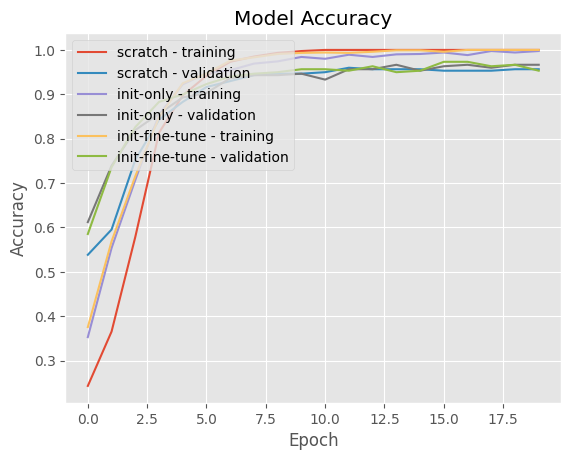

Validation accuracy in scratch mode: 0.9565
Validation accuracy in init-only mode: 0.9666
Validation accuracy in init-fine-tune mode: 0.9532


In [40]:
import matplotlib.pyplot as plt

for mode in run_modes:
    plt.plot(results[mode]['history']['accuracy'], label=f"{mode} - training")
    plt.plot(results[mode]['history']['val_accuracy'], label=f"{mode} - validation")

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

for mode in run_modes:
    print(f"Validation accuracy in {mode} mode: {results[mode]['val_accuracy']:.4f}")


#### <span style="color:red">**Question 4.3.3**</span>

**Run the above general RNN with at least five parameter sets and try to obtain the best performance. You can stick with the running mode *init-fine-tune* and use grid search to tune other parameters. Record your best model which will be used in the next part.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [41]:
# Define the parameter grid
param_grid = {
    'cell_type': ['simple-rnn', 'gru', 'lstm'],
    'network_type': ['uni-directional', 'bi-directional'],
    'state_sizes': [[32, 32], [64, 64], [128, 128]],
    'learning_rate': [0.01, 0.001, 0.0001]
}

# Store results and best model
best_accuracy = 0.0
best_model = None
best_params = None

# Results storage
results = []

# Grid search
for cell in param_grid['cell_type']:
    for net_type in param_grid['network_type']:
        for sizes in param_grid['state_sizes']:
            for lr in param_grid['learning_rate']:

                # Build the model
                rnn = RNN(run_mode=mode, cell_type='gru', network_type='uni-directional',
              embed_model='glove-wiki-gigaword-100', state_sizes=[64, 64], data_manager=dm, word2vect=word2vect)
                rnn.build()

                # Compile the model
                opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
                rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                # Train the model (consider reducing the number of epochs for grid search)
                history = rnn.fit(dm.tf_train_set.batch(64), epochs=5, validation_data=dm.tf_valid_set.batch(64))

                # Evaluate on validation set
                val_accuracy = history.history['val_accuracy'][-1]

                # Check if current model is the best
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_model = rnn
                    best_params = {'cell_type': cell, 'network_type': net_type, 'state_sizes': sizes, 'learning_rate': lr}

                # Store results
                model_result = {
                    'Configuration': {
                        'cell_type': cell,
                        'network_type': net_type,
                        'state_sizes': sizes,
                        'learning_rate': lr
                    },
                    'Validation Accuracy': val_accuracy
                }
                results.append(model_result)

# Display results
for idx, res in enumerate(results, 1):
    print(f"### Model {idx}:")
    for key, val in res['Configuration'].items():
        print(f"- **{key.capitalize()}**: {val}")
    print(f"- **Validation Accuracy**: {res['Validation Accuracy']:.2f}%")
    print("\n---\n")


Epoch 1/5
19/19 [==============================] - 19s 388ms/step - loss: 1.3679 - accuracy: 0.5129 - val_loss: 0.4679 - val_accuracy: 0.7860
Epoch 2/5
19/19 [==============================] - 4s 218ms/step - loss: 0.2213 - accuracy: 0.9276 - val_loss: 0.2929 - val_accuracy: 0.9264
Epoch 3/5
19/19 [==============================] - 4s 199ms/step - loss: 0.0827 - accuracy: 0.9700 - val_loss: 0.1108 - val_accuracy: 0.9632
Epoch 4/5
19/19 [==============================] - 4s 228ms/step - loss: 0.0185 - accuracy: 0.9933 - val_loss: 0.0752 - val_accuracy: 0.9732
Epoch 5/5
19/19 [==============================] - 5s 274ms/step - loss: 0.0181 - accuracy: 0.9967 - val_loss: 0.0648 - val_accuracy: 0.9799
Epoch 1/5
19/19 [==============================] - 16s 349ms/step - loss: 1.4987 - accuracy: 0.3847 - val_loss: 1.1112 - val_accuracy: 0.6689
Epoch 2/5
19/19 [==============================] - 5s 294ms/step - loss: 1.0899 - accuracy: 0.5978 - val_loss: 0.7667 - val_accuracy: 0.7826
Epoch 3/5
1

#Report your results here

Model 1 (run_mode ='init-fine-tune',...): accuracy = ...

......................................................

### Model 43:
- **Cell_type**: lstm
- **Network_type**: uni-directional
- **State_sizes**: [128, 128]
- **Learning_rate**: 0.01
- **Validation Accuracy**: 0.98%

In [42]:
# Best model hyperparameters
cell_type_best = 'lstm'
network_type_best = 'uni-directional'
state_sizes_best = [128, 128]
learning_rate_best = 0.01

# Build the best model using the optimal hyperparameters
my_best_rnn = RNN(run_mode=mode,
                 cell_type=cell_type_best,
                 network_type=network_type_best,
                 embed_model='glove-wiki-gigaword-100',
                 state_sizes=state_sizes_best,
                 data_manager=dm,
                 word2vect=word2vect)
my_best_rnn.build()

# Compile the model
opt_best = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_best)
my_best_rnn.compile_model(optimizer=opt_best, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the best model (you might want to increase the number of epochs for the best model)
history_best = my_best_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data=dm.tf_valid_set.batch(64))


Epoch 1/10
19/19 [==============================] - 25s 824ms/step - loss: 1.6107 - accuracy: 0.3622 - val_loss: 0.9020 - val_accuracy: 0.5284
Epoch 2/10
19/19 [==============================] - 11s 607ms/step - loss: 0.8269 - accuracy: 0.6728 - val_loss: 0.4432 - val_accuracy: 0.8930
Epoch 3/10
19/19 [==============================] - 15s 796ms/step - loss: 0.3264 - accuracy: 0.9051 - val_loss: 0.3851 - val_accuracy: 0.8896
Epoch 4/10
19/19 [==============================] - 14s 726ms/step - loss: 0.1965 - accuracy: 0.9334 - val_loss: 0.2581 - val_accuracy: 0.9264
Epoch 5/10
19/19 [==============================] - 13s 718ms/step - loss: 0.1213 - accuracy: 0.9525 - val_loss: 0.1725 - val_accuracy: 0.9398
Epoch 6/10
19/19 [==============================] - 12s 618ms/step - loss: 0.0973 - accuracy: 0.9592 - val_loss: 0.1315 - val_accuracy: 0.9398
Epoch 7/10
19/19 [==============================] - 14s 753ms/step - loss: 0.1336 - accuracy: 0.9559 - val_loss: 0.1371 - val_accuracy: 0.9465

### <span style="color:#0b486b">4.4. RNNs with Standard Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length. We compute the context vector $c$ as $c=\sum_{i=1}^{L}a_{i}h_{i}$ where $a_1,...,a_L$ are the allignment weights (i.e., $a_i\geq 0$ and $\sum_{i=1}^{L}a_{i}=1$).**

**The allignment weights are computed as follows:**
- $a=[a_{i}]_{i=1}^{L}=softmax([s_{i}]_{i=1}^{L})$ where $s= [s_{i}]_{i=1}^{L}$ consists of the allignment scores.
- The assigment scores $s= [s_{i}]_{i=1}^{L}$ are computed as $s=tanh(hU)V$ where $h=\left[\begin{array}{c}
h_{1}\\
h_{2}\\
...\\
h_{L-1}\\
h_{L}
\end{array}\right]\in\mathbb{R}^{L\times state\_size_{3}}$, $U\in\mathbb{R}^{state\_size_{3}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyper-parameter. Note that if we consider a mini-batch, the shape of $h$ is $batch\_size \times L \times state\_size_3$ where $state\_size_3$ is the hidden size of the last hidden layer.

After having the context vector $c$, we concatenate with the last hidden state $h_L$. On top of this concatenation, we conduct the output layer with the softmax activation.

<img src="./images/attention.png" align="center" width=1200/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.4.1**</span>

**We declare the  layer `MyStandardAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [43]:
import tensorflow as tf

class MyStandardAttention(tf.keras.layers.Layer):
    def __init__(self, output_length=50):
        super(MyStandardAttention, self).__init__()

        # Dense layers to compute the alignment scores
        self.U = tf.keras.layers.Dense(output_length, activation='tanh')
        self.V = tf.keras.layers.Dense(1)

    def call(self, all_states, last_state):
        # Compute the alignment scores
        s = self.V(self.U(all_states))

        # Flatten the alignment scores for softmax
        s = tf.squeeze(s, -1)

        # Compute the alignment weights using softmax
        a = tf.nn.softmax(s, axis=1)

        # Expand dimensions for weighted sum
        a_expanded = tf.expand_dims(a, -1)

        # Compute the context vector as the weighted sum of all hidden states
        c = tf.reduce_sum(a_expanded * all_states, axis=1)

        # Concatenate the context vector with the last hidden state
        concat = tf.concat([c, last_state], axis=1)

        return concat

#### <span style="color:red">**Question 4.4.2**</span>

**You are required to extend the class `RNN` in Section `4.3.1` to achieve the class `StandardAttention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [44]:
class StandardAttention_RNN(RNN):
    def __init__(self, *args, **kwargs):
        super(StandardAttention_RNN, self).__init__(*args, **kwargs)
        self.attention_layer = MyStandardAttention()

    def build(self):
        x = tf.keras.layers.Input(shape=[None])

        if self.run_mode == 'scratch':
            h = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size, mask_zero=True)(x)
        else:
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size,
                                          weights=[self.embed_matrix], trainable=(self.run_mode == 'init-fine-tune'),
                                          mask_zero=True)(x)

        num_layers = len(self.state_sizes)
        all_states = []
        for hidden_size in self.state_sizes:
            h = self.get_layer(self.cell_type, self.network_type, hidden_size,
                               return_sequences=True)(h)  # Always return sequences to capture attention at every step
            all_states.append(h)

        # Using the attention layer before the final dense layer
        last_hidden_state = all_states[-1][:, -1, :]  # Taking the last state of the last layer
        h = self.attention_layer(all_states[-1], last_hidden_state)

        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)


#### <span style="color:red">**Question 4.4.3.**</span>

**Choose a common setting for standard RNN and RNN with standard attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [53]:
# Re-instantiate and rebuild the models
standard_rnn = RNN(run_mode='scratch',
                   cell_type='gru',
                   network_type='bi-directional',
                   state_sizes=[128, 128],
                   data_manager=dm)
standard_rnn.build()

attention_rnn = StandardAttention_RNN(run_mode='scratch',
                                      cell_type='gru',
                                      network_type='bi-directional',
                                      state_sizes=[128, 128],
                                      data_manager=dm)
attention_rnn.build()

# Recompile the models
standard_rnn.compile_model(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
attention_rnn.compile_model(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [54]:
# Extract training and validation data from DataManager
train_data, train_labels = dm.train_numeral_data, dm.train_numeral_labels
val_data, val_labels = dm.valid_numeral_data, dm.valid_numeral_labels

# One-hot encode the labels
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=dm.num_classes)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels, num_classes=dm.num_classes)


# Train the standard RNN
standard_rnn.fit(train_data, train_labels_onehot, validation_data=(val_data, val_labels_onehot), epochs=10, batch_size=32)

# Train the RNN with attention
attention_rnn.fit(train_data, train_labels_onehot, validation_data=(val_data, val_labels_onehot), epochs=10, batch_size=32)



Epoch 1/10
38/38 [==============================] - 58s 1s/step - loss: 1.2425 - accuracy: 0.5479 - val_loss: 0.4678 - val_accuracy: 0.8696
Epoch 2/10
38/38 [==============================] - 31s 791ms/step - loss: 0.1717 - accuracy: 0.9467 - val_loss: 0.1873 - val_accuracy: 0.9197
Epoch 3/10
38/38 [==============================] - 32s 851ms/step - loss: 0.0344 - accuracy: 0.9908 - val_loss: 0.1147 - val_accuracy: 0.9632
Epoch 4/10
38/38 [==============================] - 32s 852ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.1349 - val_accuracy: 0.9632
Epoch 5/10
38/38 [==============================] - 31s 817ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1275 - val_accuracy: 0.9632
Epoch 6/10
38/38 [==============================] - 33s 870ms/step - loss: 8.2114e-04 - accuracy: 1.0000 - val_loss: 0.1349 - val_accuracy: 0.9599
Epoch 7/10
38/38 [==============================] - 33s 864ms/step - loss: 5.9485e-04 - accuracy: 1.0000 - val_loss: 0.1422 - val_accuracy: 0

In [55]:
# Evaluate the standard RNN on the validation data
standard_rnn_val_loss, standard_rnn_val_acc = standard_rnn.evaluate(val_data, val_labels_onehot)

# Evaluate the RNN with attention on the validation data
attention_rnn_val_loss, attention_rnn_val_acc = attention_rnn.evaluate(val_data, val_labels_onehot)

print(f"Standard RNN Validation Accuracy: {standard_rnn_val_acc}")
print(f"Attention RNN Validation Accuracy: {attention_rnn_val_acc}")


10/10 [==============================] - 1s 145ms/step - loss: 0.1561 - accuracy: 0.9599
Standard RNN Validation Accuracy: 0.9598662257194519
Attention RNN Validation Accuracy: 0.9598662257194519


### <span style="color:#0b486b">4.5. RNN with Self-Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length.**

**You need to implement the self-attention (SA) mechanism as in this paper [link](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) and this useful blog [link](https://jalammar.github.io/illustrated-transformer/) to work out the new hidden states $h_1, h_2,...,h_{L-1}, h_L$. Finally, you need take average of them $\bar{h}=\frac{h_{1}+...+h_{L}}{L}$ and rely on $\bar{h}$ to conduct the output layer for making predictions.**


<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.5.1.**</span>

**We declare the  layer `MySelfAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

**Please note that in the class `MySelfAttention`, `key_dim` is the parameter $d_k$ and `value_dim` is  the parameter $d_v$ in the main paper**


<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [58]:
import tensorflow as tf

class MySelfAttention(tf.keras.layers.Layer):
    def __init__(self, key_dim=128, value_dim=64):
        super(MySelfAttention, self).__init__()

        # These dense layers are used to project the queries, keys, and values
        self.query_dense = tf.keras.layers.Dense(units=key_dim, use_bias=False)
        self.key_dense = tf.keras.layers.Dense(units=key_dim, use_bias=False)
        self.value_dense = tf.keras.layers.Dense(units=value_dim, use_bias=False)

    def scaled_dot_product_attention(self, query, key, value):
        # Calculate the dot product, scale by sqrt of depth
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)

        # Apply softmax to get the attention weights
        weights = tf.nn.softmax(scaled_score, axis=-1)

        # Multiply weights by the values to get the context
        context = tf.matmul(weights, value)
        return context

    def call(self, all_states, last_state):
        # Project the states to get the queries, keys and values
        query = self.query_dense(last_state)
        key = self.key_dense(all_states)
        value = self.value_dense(all_states)

        # Apply attention
        context = self.scaled_dot_product_attention(query, key, value)

        # Take the mean of the context to get the final output
        output = tf.reduce_mean(context, axis=1)

        return output


#### <span style="color:red">**Question 4.5.2**</span>

**You are required to extend the class `RNN` in Section `4.3.1` to achieve the class `SelfAttention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [62]:
class SelfAttention_RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100',
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
        self.attention_layer = MySelfAttention()

    def build_embedding_matrix(self):
        #Insert your code here
        for word, idx in self.word2idx.items():
            vector = self.word2vect.get(word)
            if vector is not None:
                self.embed_matrix[idx] = vector

    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False, activation = 'tanh'):
        #Insert your code here
        if cell_type == 'gru':
            cell = tf.keras.layers.GRU(hidden_size, return_sequences=return_sequences, activation=activation)
        else:
            cell = tf.keras.layers.LSTM(hidden_size, return_sequences=return_sequences, activation=activation)

        if network_type == 'bi-directional':
            return tf.keras.layers.Bidirectional(cell)
        else:
            return cell

    def build(self):
        #Insert your code here
        x = tf.keras.layers.Input(shape=[None])

        if self.run_mode == 'scratch':
            h = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size, mask_zero=True)(x)
        else:
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size,
                                          weights=[self.embed_matrix], trainable=(self.run_mode == 'init-fine-tune'),
                                          mask_zero=True)(x)

        for hidden_size in self.state_sizes:
            h = self.get_layer(self.cell_type, self.network_type, hidden_size, return_sequences=True)(h)

        # Apply the attention mechanism
        last_hidden_state = h[:, -1, :]
        h = self.attention_layer(h, last_hidden_state)

        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        return self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 4.5.3.**</span>

**Choose a common setting for standard RNN and RNN with self attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [63]:
#Your trial here
train_data, train_labels = dm.train_numeral_data, dm.train_numeral_labels
val_data, val_labels = dm.valid_numeral_data, dm.valid_numeral_labels
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=dm.num_classes)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels, num_classes=dm.num_classes)

# 1. Standard RNN
standard_rnn = SelfAttention_RNN(run_mode='scratch', cell_type='gru', network_type='bi-directional', state_sizes=[128, 128], data_manager=dm)
standard_rnn.build()
standard_rnn.compile_model(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
standard_rnn.fit(train_data, train_labels_onehot, validation_data=(val_data, val_labels_onehot), epochs=10, batch_size=32)
standard_acc = standard_rnn.evaluate(val_data, val_labels_onehot)[1]

# 2. RNN with Self-Attention
attention_rnn = SelfAttention_RNN(run_mode='scratch', cell_type='gru', network_type='bi-directional', state_sizes=[128, 128], data_manager=dm)
attention_rnn.build()
attention_rnn.compile_model(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
attention_rnn.fit(train_data, train_labels_onehot, validation_data=(val_data, val_labels_onehot), epochs=10, batch_size=32)
attention_acc = attention_rnn.evaluate(val_data, val_labels_onehot)[1]

print(f"Standard RNN Accuracy: {standard_acc}")
print(f"Attention RNN Accuracy: {attention_acc}")



Epoch 1/10
38/38 [==============================] - 77s 1s/step - loss: 1.6532 - accuracy: 0.3339 - val_loss: 1.3959 - val_accuracy: 0.3813
Epoch 2/10
38/38 [==============================] - 33s 872ms/step - loss: 0.7217 - accuracy: 0.7835 - val_loss: 0.5799 - val_accuracy: 0.9030
Epoch 3/10
38/38 [==============================] - 36s 953ms/step - loss: 0.2418 - accuracy: 0.9550 - val_loss: 0.3151 - val_accuracy: 0.9064
Epoch 4/10
38/38 [==============================] - 33s 872ms/step - loss: 0.1092 - accuracy: 0.9742 - val_loss: 0.2837 - val_accuracy: 0.9431
Epoch 5/10
38/38 [==============================] - 33s 873ms/step - loss: 0.0380 - accuracy: 0.9983 - val_loss: 0.1750 - val_accuracy: 0.9632
Epoch 6/10
38/38 [==============================] - 33s 881ms/step - loss: 0.0311 - accuracy: 0.9967 - val_loss: 0.1762 - val_accuracy: 0.9599
Epoch 7/10
38/38 [==============================] - 33s 874ms/step - loss: 0.0215 - accuracy: 0.9983 - val_loss: 0.3438 - val_accuracy: 0.9331
Ep

### <span style="color:#0b486b">4.6. Investigating the embedding vectors from the embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `consine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $\mathcal{L}_2$ norm.**

In [70]:
def cosine_similarity(u, v):
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    if norm_u == 0 or norm_v == 0:
        return 0
    return np.dot(u, v) / (norm_u * norm_v)

#### <span style="color:red">**Question 4.6.1**</span>

**You are required to write the code for the function `find_most_similar(word= None, k=5, model= None)`. As its name, this function returns the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [71]:
def find_most_similar(word=None, k=5, model=None):
    try:
        word_idx = model.word2idx[word]
        word_vector = model.embed_matrix[word_idx]

        # Compute cosine similarities
        similarities = [cosine_similarity(word_vector, vec) for vec in model.embed_matrix]

        # Get the indices of the top-k most similar words
        sorted_indices = np.argsort(similarities)[::-1]
        top_k_indices = sorted_indices[1:k+1]  # Exclude the word itself

        # Convert indices to words
        idx2word = {v: k for k, v in model.word2idx.items()}
        top_k_words = [idx2word[idx] for idx in top_k_indices]

        return top_k_words
    except:  # word not in the vocabulary
        print("Word is not in the dictionary!")

Here is the example of the above function. As you can observe, the result makes sense which demonstrates that we obtain a good model with the meaningful embedding matrix.

In [72]:
find_most_similar(word='poland', k=10, model= my_best_rnn)

['germany',
 'russia',
 'republic',
 'netherlands',
 'italy',
 'belgium',
 'europe',
 'soviet',
 'turkey',
 'malta']

#### <span style="color:red">**Question 4.6.2**</span>
​
**You are required to write the code for the function `plot3D_with_labels(word= None, model= None, k= 10)`. As its name, this function visualizes the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors by using tSNE to project the embedding vectors to a 3D space.**
​

<img src="./images/3D_plots.png" align="center" width=600/>
<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [77]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)
def plot3D_with_labels(word=None, model=None, k=10):
    # Set perplexity to min(k, 30) to ensure it's less than the number of samples
    tsne = TSNE(perplexity=min(k, 30), n_components=3, init='pca', n_iter=5000)

    # Get the top-k most similar words
    similar_words = [word] + find_most_similar(word, k, model)
    word_indices = [model.word2idx[w] for w in similar_words]
    vectors = np.array([model.embed_matrix[idx] for idx in word_indices])  # Convert to numpy array

    # Use t-SNE to reduce dimensionality
    low_dim_vectors = tsne.fit_transform(vectors)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i, label in enumerate(similar_words):
        x, y, z = low_dim_vectors[i, :]
        ax.scatter(x, y, z, label=label)
        ax.text(x, y, z, label)
    plt.show()

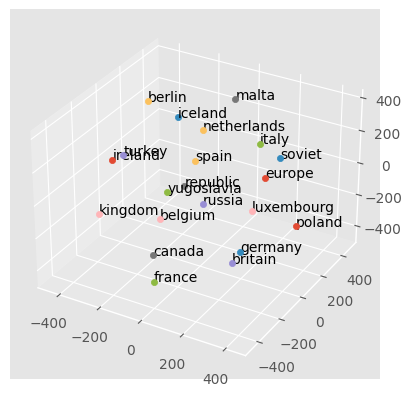

In [78]:
plot3D_with_labels(word='poland', k=20, model= rnn)

---
<div style="text-align: center"> <span style="color:green">GOOD LUCK WITH YOUR ASSIGNMENT 2!</span> </div>
<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>